In [9]:
# import modules
import uproot, sys, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import awkward as ak
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

# Set up plot defaults
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font
sns.set(style="whitegrid")

In [3]:
def getWeight(fb, sample):
    lumi = 25767.5
    weight = fb['mconly_weight']/fb['mc_weight_sum']*fb['xsec_ami']*fb['filter_eff_ami']*fb['kfactor_ami']*fb['pu_weight']*fb['jvt_weight']*1000*lumi
    if sample in ['ggHyyd','WH','VBF','ZH'] : 
        xsec_sig = 0.052 #if ( period == 'Run3' or 'mc23' in period ) else 0.048
        # if sample != 'ggHyyd' : xsec_sig = fb['xsec_ami']
        br = 0.01
        weight = fb['mconly_weight']/fb['mc_weight_sum']*xsec_sig*fb['pu_weight']*fb['jvt_weight']*fb['filter_eff_ami']*fb['kfactor_ami']*1000*lumi*br
    return weight

def getSampleDict():
    sample_dict = {}
    sample_dict['Zjets'] = {
        'color': 'darkgreen',   # approximates ROOT.kGreen-2
        'legend': r'Z($\nu\nu$, ll)+jets',
        'tree': 'nominal',
        'filenames': ['Zjets']
    }
    sample_dict['Zgamma'] = {
        'color': '#e6550d',      # approximates ROOT.kOrange+7
        'legend': r'Z($\nu\nu$)+$\gamma$',
        'tree': 'nominal',
        'filenames': ['Zgamma']
    }
    sample_dict['Wgamma'] = {
        'color': 'darkorange',  # approximates ROOT.kOrange+1
        'legend': r'W($l\nu$)+$\gamma$',
        'tree': 'nominal',
        'filenames': ['Wgamma']
    }
    sample_dict['Wjets'] = {
        'color': 'teal',        # approximates ROOT.kTeal+5
        'legend': r'W($l\nu$)+jets',
        'tree': 'nominal',
        'filenames': ['Wjets']
    }
    sample_dict['gammajet_direct'] = {
        'color': 'royalblue',   # approximates ROOT.kBlue+2
        'legend': r'$\gamma$+jets direct',
        'tree': 'gammajets',
        'filenames': ['gammajet_direct']
    }
    sample_dict['gammajet_frag'] = {
        'color': 'navy',        # approximates ROOT.kBlue-5
        'legend': r'$\gamma$+jets frag',
        'tree': 'gammajets',
        'filenames': ['gammajet_frag']
    }
    sample_dict['dijet'] = {
        'color': 'cyan',        # approximates ROOT.kCyan+1
        'legend': 'multijets',
        'tree': 'dijets',
        'filenames': ['dijet']
    }
    sample_dict['ggHyyd'] = {
        'color': 'red',         # approximates ROOT.kRed
        'legend': r'ggH, H$\rightarrow\gamma\gamma_{d}$',
        'tree': 'nominal',
        'filenames': ['ggHyyd']
    }
    return sample_dict
sample_dict = getSampleDict()

def getVarDict(fb, process, var_name=None):
    var_dict = {}

    # this has the same size as weight, so don't need adjustment on weighting
    if var_name is None or var_name == 'vtx_sumPt':
        var_dict['vtx_sumPt'] = {
            'var': ak.flatten(fb['vtx_sumPt']),
            'bins': np.linspace(0, 100, 20+1),  # 21 edges for 20 bins
            'title': r'vtx\_sumPt'
        }

    if var_name is None or var_name == 'n_ph':
        var_dict['n_ph'] = {
            'var': fb['n_ph'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{ph}$'
        }

    if var_name is None or var_name == 'n_ph_baseline':
        var_dict['n_ph_baseline'] = {
            'var': fb['n_ph_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{ph\_baseline}$'
        }

    if var_name is None or var_name == 'n_el_baseline':
        var_dict['n_el_baseline'] = {
            'var': fb['n_el_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{el\_baseline}$'
        }

    if var_name is None or var_name == 'n_mu_baseline':
        var_dict['n_mu_baseline'] = {
            'var': fb['n_mu_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{mu\_baseline}$'
        }

    if var_name is None or var_name == 'n_tau_baseline':
        var_dict['n_tau_baseline'] = {
            'var': fb['n_tau_baseline'],
            'bins': np.linspace(0, 7, 7+1),
            'title': r'$N_{tau\_baseline}$'
        }

    if var_name is None or var_name == 'puWeight':
        var_dict['puWeight'] = {
            'var': fb['pu_weight'],
            'bins': np.linspace(0, 2, 50+1),
            'title': r'PU weight',
            'shift': '+0'
        }

    if var_name is None or var_name == 'actualIntPerXing':
        var_dict['actualIntPerXing'] = {
            'var': fb['actualIntPerXing'],
            'bins': np.linspace(0, 100, 50+1),
            'title': r'$\langle\mu\rangle$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'mt':
        var_dict['mt'] = {
            'var': np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                           (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000,
            'bins': np.linspace(0, 300, 15+1),
            'title': r'$m_T\ [GeV]$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'metsig':
        var_dict['metsig'] = {
            'var': fb['met_tst_sig'],
            'bins': np.linspace(0, 30, 15+1),
            'title': r'$E_T^{miss}\ significance$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'metsigres':
        var_dict['metsigres'] = {
            'var': fb['met_tst_et'] / fb['met_tst_sig'],
            'bins': np.linspace(0, 100000, 50+1),
            'title': r'$E_T^{miss}\ significance$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'met':
        var_dict['met'] = {
            'var': fb['met_tst_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ [GeV]$',
            'shift': '+50000'
        }

    if var_name is None or var_name == 'met_noJVT':
        var_dict['met_noJVT'] = {
            'var': fb['met_tst_noJVT_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ [GeV]$'
        }

    if var_name is None or var_name == 'met_cst':
        var_dict['met_cst'] = {
            'var': fb['met_cst_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ CST\ [GeV]$'
        }

    if var_name is None or var_name == 'met_track':
        var_dict['met_track'] = {
            'var': fb['met_track_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}\ Track\ [GeV]$'
        }

    if var_name is None or var_name == 'dmet':
        var_dict['dmet'] = {
            'var': fb['met_tst_noJVT_et'] - fb['met_tst_et'],
            'bins': np.linspace(-100000, 100000, 20+1),
            'title': r'$E_{T,\mathrm{noJVT}}^{miss}-E_T^{miss}\ [GeV]$',
            'shift': '*1'
        }

    if var_name is None or var_name == 'ph_pt':
        var_dict['ph_pt'] = {
            'var': ak.firsts(fb['ph_pt']),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{\gamma}\ [GeV]$',
            'shift': '-150000'
        }

    if var_name is None or var_name == 'ph_eta':
        var_dict['ph_eta'] = {
            'var': np.abs(ak.firsts(fb['ph_eta'])),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\eta^{\gamma}$'
        }

    if var_name is None or var_name == 'ph_phi':
        var_dict['ph_phi'] = {
            'var': ak.firsts(fb['ph_phi']),
            'bins': np.linspace(-4, 4, 50+1),
            'title': r'$\phi^{\gamma}$'
        }

    if var_name is None or var_name == "jet_central_eta":
        jet_central_eta_tmp = ak.firsts(fb['jet_central_eta'])
        var_dict['jet_central_eta'] = {
            'var': ak.fill_none(jet_central_eta_tmp, -999),
            'bins': np.linspace(-4, 4, 50+1), 
            'title': r'$\eta^{\mathrm{jets}}$'
        }

    # Jet central pt1 (first jet)
    if var_name is None or var_name == "jet_central_pt1":
        jet_central_pt1_tmp = ak.firsts(fb['jet_central_pt'])
        var_dict['jet_central_pt1'] = {
            'var': ak.fill_none(jet_central_pt1_tmp, -999),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{j1}\ [GeV]$'
        }

    # Jet central pt2 (second jet, if available)
    if var_name is None or var_name == "jet_central_pt2":
        jet_central_pt2_tmp = ak.mask(fb['jet_central_pt'], ak.num(fb['jet_central_pt']) >= 2)[:, 1]
        var_dict['jet_central_pt2'] = {
            'var': ak.fill_none(jet_central_pt2_tmp, -999),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{j2}\ [GeV]$'
        }

    # Jet central pt (all jets)
    if var_name is None or var_name == "jet_central_pt":
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['jet_central_pt'])[0])
        var_dict['jet_central_pt'] = {
            'var': ak.flatten(fb['jet_central_pt']),
            'weight': expanded_weights,
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{j}\ [GeV]$'
    }

    if var_name is None or var_name == 'dphi_met_phterm':
        var_dict['dphi_met_phterm'] = {
            'var': np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})$',
            'shift': '+0'
        }

    if var_name is None or var_name == 'dphi_met_ph':
        var_dict['dphi_met_ph'] = {
            'var': np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi']))),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{\gamma})$'
        }

    if var_name is None or var_name == 'dphi_met_jetterm':
        var_dict['dphi_met_jetterm'] = {
            'var': np.where(fb['met_jetterm_et'] != 0,
                            np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
                            -999),
            'bins': np.linspace(0, 4, 16+1),
            'title': r'$\Delta\phi(E_T^{miss},\, E_T^{jet})$'
        }

    if var_name is None or var_name == 'dphi_phterm_jetterm':
        var_dict['dphi_phterm_jetterm'] = {
            'var': np.where(fb['met_jetterm_et'] > 0,
                            np.arccos(np.cos(fb['met_phterm_phi'] - fb['met_jetterm_phi'])),
                            -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{\gamma},\, E_T^{jet})$'
        }

    # Delta phi (photon vs. central jet1)
    if var_name is None or var_name == 'dphi_ph_centraljet1':
        dphi_ph_centraljet1_tmp = np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi'])))
        var_dict['dphi_ph_centraljet1'] = {
            'var': ak.fill_none(dphi_ph_centraljet1_tmp, -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(\gamma,\, j1)$'
        }


    # # Delta phi (central jet1 vs. jet2) (repeated with dphi_jj)
    # if var_name is None or var_name == 'dphi_central_jet1_jet2':
    #     phi1_tmp = ak.firsts(fb['jet_central_phi'])
    #     phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1]
    #     dphi_central_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
    #     var_dict['dphi_central_jet1_jet2'] = {
    #         'var': ak.fill_none(dphi_central_tmp, -999),
    #         'bins': np.linspace(0, 4, 50+1),
    #         'title': r'$\Delta\phi(j1,\, j2)$'
    #     }

    # Met plus photon pt
    if var_name is None or var_name == 'metplusph':
        var_dict['metplusph'] = {
            'var': fb['met_tst_et'] + ak.firsts(fb['ph_pt']),
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{miss}+p_T^{\gamma}\ [GeV]$'
        }

    # # Fail JVT jet pt (all)
    if var_name is None or var_name == 'failJVT_jet_pt':
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['failJVT_jet_pt'])[0])
        var_dict['failJVT_jet_pt'] = {
            'var': ak.flatten(fb['failJVT_jet_pt']),
            'weight': expanded_weights,
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$p_T^{\mathrm{noJVT\ jet}}\ [GeV]$'
        }

    # # Fail JVT jet pt1 (first element)
    if var_name is None or var_name == 'failJVT_jet_pt1':
        failJVT_jet_pt_tmp = ak.firsts(fb['failJVT_jet_pt'])
        var_dict['failJVT_jet_pt1'] = {
            'var': ak.fill_none(failJVT_jet_pt_tmp, -999),
            'bins': np.linspace(20000, 60000, 40+1),
            'title': r'$p_T^{\mathrm{noJVT\ jet1}}\ [GeV]$'
        }

    if var_name is None or var_name == 'softerm':
        var_dict['softerm'] = {
            'var': fb['met_softerm_tst_et'],
            'bins': np.linspace(0, 100000, 50+1),
            'title': r'$E_T^{soft}\ [GeV]$'
        }

    if var_name is None or var_name == 'jetterm':
        var_dict['jetterm'] = {
            'var': fb['met_jetterm_et'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{jet}\ [GeV]$'
        }

    if var_name is None or var_name == 'jetterm_sumet':
        var_dict['jetterm_sumet'] = {
            'var': fb['met_jetterm_sumet'],
            'bins': np.linspace(0, 300000, 50+1),
            'title': r'$E_T^{jet}\ [GeV]$'
        }

    if var_name is None or var_name == 'n_jet':
        var_dict['n_jet'] = {
            'var': fb['n_jet'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}$'
        }

    if var_name is None or var_name == 'n_jet_central':
        var_dict['n_jet_central'] = {
            'var': fb['n_jet_central'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}^{central}$'
        }

    if var_name is None or var_name == 'n_jet_fwd':
        var_dict['n_jet_fwd'] = {
            'var': fb['n_jet'] - fb['n_jet_central'],
            'bins': np.linspace(0, 10, 10+1),
            'title': r'$N_{jet}^{fwd}$'
        }

    # if var_name is None or var_name == 'vertex':
    #     var_dict['vertex'] = {
    #         'var': (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) == 
    #                 np.min(np.abs(ak.firsts(fb['pv_truth_z']) - fb['pv_z']))),
    #         'bins': np.linspace(0, 2, 2+1),
    #         'title': r'good PV'
    #     }

    if var_name is None or var_name == 'goodPV':
        var_dict['goodPV'] = {
            'var': (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5),
            'bins': np.linspace(0, 2, 2+1),
            'title': r'good PV'
        }
    # # Delta phi (met vs. central jet)
    if var_name is None or var_name == 'dphi_met_central_jet':
        dphi_met_central_jet_tmp = np.arccos(np.cos(fb['met_tst_phi'] - ak.firsts(fb['jet_central_phi'])))
        var_dict['dphi_met_central_jet'] = {
            'var': ak.fill_none(dphi_met_central_jet_tmp, -999),
            'bins': np.linspace(0, 4, 50+1),
            'title': r'$\Delta\phi(E_T^{miss},\, jet)$'
        }

    # # Counts: constant 0.5 (typically used for normalization)
    # var_dict['counts'] = {
    #     'var': 0.5,
    #     'bins': np.linspace(0, 1, 1+1),
    #     'title': ''
    # }

    # # Jet central timing1
    if var_name is None or var_name == 'jet_central_timing1':
        jet_central_timing1_tmp = ak.firsts(fb['jet_central_timing'])
        var_dict['jet_central_timing1'] = {
            'var': ak.fill_none(jet_central_timing1_tmp, -999),
            'bins': np.linspace(-40, 40, 50+1),
            'title': r'$Jet\ timing$'
        }

    # # Jet central timing (all)
    if var_name is None or var_name == 'jet_central_timing':
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['jet_central_timing'])[0])
        var_dict['jet_central_timing'] = {
            'var': ak.flatten(fb['jet_central_timing']),
            'weight': expanded_weights,
            'bins': np.linspace(-40, 40, 50+1),
            'title': r'$Jet\ timing$'
        }

    # # Jet central EM fraction
    if var_name is None or var_name == 'jet_central_emfrac':
        weight_tmp = getWeight(fb, process)
        expanded_weights = ak.flatten(ak.broadcast_arrays(weight_tmp, fb['jet_central_emfrac'])[0])
        var_dict['jet_central_emfrac'] = {
            'var': ak.flatten(fb['jet_central_emfrac']),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'$Jet\ EM\ fraction$'
        }

    if var_name is None or var_name == 'jet_central_emfrac':
        jet_central_emfrac1_tmp = ak.firsts(fb['jet_central_emfrac'])
        var_dict['jet_central_emfrac'] = {
            'var': ak.fill_none(jet_central_emfrac1_tmp, -999),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'$Jet\ EM\ fraction$'
        }


    # Balance: (met_tst_et+ph_pt[0]) divided by the sum over jet_central_pt.
    if var_name is None or var_name == 'balance':
        jet_sum_tmp = ak.sum(fb['jet_central_pt'], axis=-1)
        expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(jet_sum_tmp != 0, jet_sum_tmp, 1)
        balance = ak.where(jet_sum_tmp != 0, expr, -999) 

        var_dict['balance'] = {
            'var': balance,
            'bins': np.linspace(0, 20, 100+1),
            'title': r'balance'
        }

    if var_name is None or var_name == 'balance_sumet':
        sumet_tmp = fb['met_jetterm_sumet']
        expr = (fb['met_tst_et'] + ak.firsts(fb['ph_pt'])) / ak.where(sumet_tmp != 0, sumet_tmp, 1)
        balance_sumet = ak.where(sumet_tmp != 0, expr, -999)

        var_dict['balance_sumet'] = {
            'var': balance_sumet,
            'bins': np.linspace(0, 80, 80+1),
            'title': r'balance'
        }

    if var_name is None or var_name == 'central_jets_fraction':
        var_dict['central_jets_fraction'] = {
            'var': np.where(fb['n_jet'] > 0, fb['n_jet_central']/fb['n_jet'], -1),
            'bins': np.linspace(-1, 2, 50+1),
            'title': r'Central jets fraction'
        }

    if var_name is None or var_name == 'trigger':
        var_dict['trigger'] = {
            'var': fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M'],
            'bins': np.linspace(0, 2, 2+1),
            'title': r'Pass Trigger'
        }

    # dphi_jj: Use Alt$ logic – if jet_central_phi has at least two entries, compute the difference; else -1.
    # Here we use a Python conditional (this assumes fb['jet_central_phi'] is an array with shape information).
    if var_name is None or var_name == 'dphi_jj':
        phi1_tmp = ak.firsts(fb['jet_central_phi'])
        phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1]
        dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
        var_dict['dphi_jj'] = {
            'var': ak.fill_none(dphi_tmp, -999),
            'bins': np.linspace(-1, 4, 20+1),
            'title': r'$\Delta\phi(j1,\, j2)$'
        }
    
    if var_name is None or var_name == 'BDTScore':
        var_dict['BDTScore'] = {
            'var': fb['BDTScore'],
            'bins': np.arange(0, 1+0.1, 0.1),
            'title': 'BDTScore'
        }
    
    return var_dict

In [4]:
# Testing
sample_dict['ggHyyd']['color']

'red'

In [ ]:
!ls /data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT

data23_uy_BDT_score.root		 mc23d_Wgamma_uy_BDT_score.root
data23_y_BDT_score.root			 mc23d_Wgamma_y_BDT_score.root
mc23d_dijets_y_BDT_score.root		 mc23d_Wjets_uy_BDT_score.root
mc23d_gammajet_direct_uy_BDT_score.root  mc23d_Wjets_y_BDT_score.root
mc23d_gammajet_direct_y_BDT_score.root	 mc23d_Zgamma_uy_BDT_score.root
mc23d_gammajet_frag_uy_BDT_score.root	 mc23d_Zgamma_y_BDT_score.root
mc23d_gammajet_frag_y_BDT_score.root	 mc23d_Zjets_uy_BDT_score.root
mc23d_ggHyyd_uy_BDT_score.root		 mc23d_Zjets_y_BDT_score.root
mc23d_ggHyyd_y_BDT_score.root


In [7]:
path = "/data/tmathew/ntups/mc23d/ggHyyd_y.root"
path = "/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_ggHyyd_y_BDT_score.root"
f = uproot.open(path)['nominal']
f.keys()

['run',
 'randomRunNumber',
 'event',
 'year',
 'averageIntPerXing',
 'actualIntPerXing',
 'corAverageIntPerXing',
 'corActualIntPerXing',
 'trigger_HLT_g100_loose_L1EM22VHI',
 'trigger_HLT_g100_loose_L1eEM26M',
 'trigger_HLT_g100_loose_L1eEM28M',
 'trigger_HLT_g120_loose_L1EM22VHI',
 'trigger_HLT_g120_loose_L1eEM26M',
 'trigger_HLT_g120_loose_L1eEM28MHLT_g25_loose_L1EM20VH',
 'trigger_HLT_g140_loose_L1EM22VHI',
 'trigger_HLT_g140_loose_L1eEM26M',
 'trigger_HLT_g25_loose_L1eEM24L',
 'trigger_HLT_g30_loose_L1EM20VH',
 'trigger_HLT_g30_loose_L1eEM24L',
 'trigger_HLT_g40_loose_L1EM20VH',
 'trigger_HLT_g40_loose_L1eEM24L',
 'trigger_HLT_g50_loose_L1EM20VH',
 'trigger_HLT_g50_loose_L1eEM24L',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe50_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_EM22VHI',
 'trigger_HLT_g50_tight_xe40_cell_xe60_pfopufit_80mTAC_L1eEM26M',
 'trigger_HLT_g50_tight_xe40_cell_xe70_pf

In [4]:
variables = [
    "actualIntPerXing",
    "failJVT_jet_pt",
    "jet_central_emfrac",
    "jet_central_eta",
    "jet_central_phi",
    "jet_central_pt",
    "jet_central_timing",
    # "jet_jvt",
    "met_cst_et",
    "met_jetterm_et",
    "met_jetterm_phi",
    "met_jetterm_sumet",
    "met_phterm_phi",
    "met_softerm_tst_et",
    "met_tst_et",
    "met_tst_noJVT_et",
    "met_tst_phi",
    "met_tst_sig",
    "met_track_et",
    'n_ph',
    'n_ph_baseline',
    'n_el_baseline',
    'n_mu_baseline',
    "n_jet",
    "n_jet_central",
    "n_tau_baseline",
    "ph_eta",
    "ph_phi",
    "ph_pt",
    "pu_weight",
    "pv_truth_z",
    "pv_z",
    "trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M",
    'vtx_sumPt',
    'mconly_weight',
    'mc_weight_sum',
    'xsec_ami',
    'filter_eff_ami',
    'kfactor_ami',
    'pu_weight',
    'jvt_weight',
    'event'
]
ntuple_name = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct','gammajet_frag','dijet']
ntuple_name_BDT = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct','gammajet_frag','dijets']

tot = []
data = pd.DataFrame()
unweighted_bcut, weighted_bcut, unweighted_acut, weighted_acut = [], [], [], []

def test(fb):
    # checking if there are any none values
    mask = ak.is_none(fb['met_tst_et'])
    n_none = ak.sum(mask)
    print("Number of none values: ", n_none)
    # if n_none > 0:
    #     fb = fb[~mask]
    # print("Events after removing none values: ", len(fb), ak.sum(ak.is_none(fb['met_tst_et'])))

# i = 0
for i in range(len(ntuple_name)):
    cut = []
    start_time = time.time()
    path = f"/data/tmathew/ntups/mc23d/{ntuple_name[i]}_y.root" 
    path_BDT = f"/data/fpiazza/ggHyyd/Ntuples/MC23d/withVertexBDT/mc23d_{ntuple_name_BDT[i]}_y_BDT_score.root" 
    print('processing file: ', path)
    f = uproot.open(path)['nominal']
    fb = f.arrays(variables, library="ak")

    # add BDT score to fb
    f_BDT = uproot.open(path_BDT)['nominal']
    fb_BDT = f_BDT.arrays(["event", "BDTScore"], library="ak")
    tmp = fb["event"] == fb_BDT["event"]
    if np.all(tmp) == True:
        fb["BDTScore"] = fb_BDT["BDTScore"]
    else: 
        print("Something is wrong, need arranging")
    

    print("Unweighted Events before cut: ", len(fb))
    print("Weighted Events before cut: ", sum(getWeight(fb, ntuple_name[i])))
    unweighted_bcut.append(len(fb))
    weighted_bcut.append(sum(getWeight(fb, ntuple_name[i])))


    fb = fb[fb['n_ph_baseline'] == 1]
    fb = fb[fb['n_ph'] == 1]
    fb = fb[fb['n_mu_baseline'] == 0]
    fb = fb[fb['n_el_baseline'] == 0]
    fb = fb[fb['n_tau_baseline'] == 0]
    fb = fb[fb['trigger_HLT_g50_tight_xe40_cell_xe70_pfopufit_80mTAC_L1eEM26M']==1]
    fb = fb[ak.num(fb['ph_pt']) > 0] # prevent none values in Tbranch
    fb = fb[fb['met_tst_et'] >= 100000] # MET cut (basic cut)
    fb = fb[ak.firsts(fb['ph_pt']) >= 50000] # ph_pt cut (basic cut)
    # goodPV on signal only
    if ntuple_name[i] == 'ggHyyd':
        fb = fb[ak.num(fb['pv_z']) > 0]
        good_pv_tmp = (np.abs(ak.firsts(fb['pv_truth_z']) - ak.firsts(fb['pv_z'])) <= 0.5)
        fb = fb[good_pv_tmp]

    mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) * 
                            (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    mask1 = mt_tmp >= 80 # trigger cut
    fb = fb[mask1]
    cut.append(len(fb))

    fb = fb[fb['BDTScore'] >= 0.1] # added cut 1
    cut.append(len(fb))

    # metsig_tmp = fb['met_tst_sig'] # added cut 2 
    # mask1 = metsig_tmp >= 7
    # mask2 = metsig_tmp <= 16
    # fb = fb[mask1 * mask2]
    # cut.append(len(fb))

    # dphi_met_phterm_tmp = np.arccos(np.cos(fb['met_tst_phi'] - fb['met_phterm_phi'])) # added cut 3
    # fb = fb[dphi_met_phterm_tmp >= 1.3]
    # cut.append(len(fb))

    # dmet_tmp = fb['met_tst_noJVT_et'] - fb['met_tst_et'] # added cut 4
    # mask1 = dmet_tmp >= -20000
    # mask2 = dmet_tmp <= 50000
    # fb = fb[mask1 * mask2]
    # cut.append(len(fb))

    # dphi_met_jetterm_tmp = np.where(fb['met_jetterm_et'] != 0,   # added cut 5
    #                         np.arccos(np.cos(fb['met_tst_phi'] - fb['met_jetterm_phi'])),
    #                         -999)
    # fb = fb[dphi_met_jetterm_tmp <= 0.75]

    # ph_eta_tmp = np.abs(ak.firsts(fb['ph_eta'])) # added cut 6
    # fb = fb[ph_eta_tmp <= 1.75]
    # cut.append(len(fb))
    
    # # dphi_ph_centraljet1_tmp = np.arccos(np.cos(ak.firsts(fb['ph_phi']) - ak.firsts(fb['jet_central_phi']))) # added cut 4
    # # dphi_ph_centraljet1_tmp = ak.fill_none(dphi_ph_centraljet1_tmp, -999)
    # # valid_mask = dphi_ph_centraljet1_tmp != -999 # keeping -999 values
    # # dphi_ph_centraljet1 = ak.mask(dphi_ph_centraljet1_tmp, (dphi_ph_centraljet1_tmp >= 1.5) | ~valid_mask)
    # # fb = fb[~ak.is_none(dphi_ph_centraljet1)]
    # # cut.append(len(fb))

    # phi1_tmp = ak.firsts(fb['jet_central_phi']) # added cut 7
    # phi2_tmp = ak.mask(fb['jet_central_phi'], ak.num(fb['jet_central_phi']) >= 2)[:, 1] 
    # dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
    # dphi_jj_tmp = ak.fill_none(dphi_tmp, -1)
    # fb = fb[dphi_jj_tmp <= 2.5]
    # cut.append(len(fb))
    
    # mt_tmp = np.sqrt(2 * fb['met_tst_et'] * ak.firsts(fb['ph_pt']) *     # added cut 8
    #                         (1 - np.cos(fb['met_tst_phi'] - ak.firsts(fb['ph_phi'])))) / 1000
    # mask1 = mt_tmp >= 95 # trigger cut
    # fb = fb[mask1]
    # cut.append(len(fb))


    print("Unweighted Events after cut: ", len(fb))
    print("Weighted Events after cut: ", sum(getWeight(fb, ntuple_name[i])))

    unweighted_acut.append(cut)
    # unweighted_acut.append(len(fb))
    weighted_acut.append(sum(getWeight(fb, ntuple_name[i])))
    test(fb) # check for none value

    print(f"Reading Time for {ntuple_name[i]}: {(time.time()-start_time)} seconds\n")



    tot.append(fb)

    fb = 0
    fb_BDT = 0
    tmp = 0


processing file:  /data/tmathew/ntups/mc23d/ggHyyd_y.root
Unweighted Events before cut:  225374
Weighted Events before cut:  4373.655
Unweighted Events after cut:  4577
Weighted Events after cut:  88.40615
Number of none values:  0
Reading Time for ggHyyd: 4.3585686683654785 seconds

processing file:  /data/tmathew/ntups/mc23d/Zjets_y.root
Unweighted Events before cut:  11544081
Weighted Events before cut:  330316.28
Unweighted Events after cut:  20682
Weighted Events after cut:  182.73033
Number of none values:  0
Reading Time for Zjets: 110.26672863960266 seconds

processing file:  /data/tmathew/ntups/mc23d/Zgamma_y.root
Unweighted Events before cut:  4341141
Weighted Events before cut:  59228.0
Unweighted Events after cut:  770865
Weighted Events after cut:  3453.374
Number of none values:  0
Reading Time for Zgamma: 50.209768772125244 seconds

processing file:  /data/tmathew/ntups/mc23d/Wgamma_y.root
Unweighted Events before cut:  1772654
Weighted Events before cut:  108356.71
Unwe

In [7]:
def cut(tot):
    output = []
    for i in range(len(tot)):
        tree = tot[i]

        metsig_tmp = tree['met_tst_sig'] # added cut 2 
        mask1 = metsig_tmp >= 7
        mask2 = metsig_tmp <= 16
        tree = tree[mask1 * mask2]

        # dphi_met_phterm_tmp = np.arccos(np.cos(tree['met_tst_phi'] - tree['met_phterm_phi'])) # added cut 3
        # tree = tree[dphi_met_phterm_tmp >= 1.3]

        dmet_tmp = tree['met_tst_noJVT_et'] - tree['met_tst_et'] # added cut 4
        mask1 = dmet_tmp >= -20000
        mask2 = dmet_tmp <= 50000
        tree = tree[mask1 * mask2]

        dphi_met_jetterm_tmp = np.where(tree['met_jetterm_et'] != 0,   # added cut 5
                                np.arccos(np.cos(tree['met_tst_phi'] - tree['met_jetterm_phi'])),
                                -999)
        tree = tree[dphi_met_jetterm_tmp <= 0.75]

        ph_eta_tmp = np.abs(ak.firsts(tree['ph_eta'])) # added cut 6
        tree = tree[ph_eta_tmp <= 1.75]

        phi1_tmp = ak.firsts(tree['jet_central_phi']) # added cut 7
        phi2_tmp = ak.mask(tree['jet_central_phi'], ak.num(tree['jet_central_phi']) >= 2)[:, 1] 
        dphi_tmp = np.arccos(np.cos(phi1_tmp - phi2_tmp))
        dphi_jj_tmp = ak.fill_none(dphi_tmp, -1)
        tree = tree[dphi_jj_tmp <= 2.5]
        
        mt_tmp = np.sqrt(2 * tree['met_tst_et'] * ak.firsts(tree['ph_pt']) *     # added cut 8
                                (1 - np.cos(tree['met_tst_phi'] - ak.firsts(tree['ph_phi'])))) / 1000
        mask1 = mt_tmp >= 95 # trigger cut
        tree = tree[mask1]
        print(f"Reading Time for {ntuple_name[i]}: {(time.time()-start_time)} seconds\n")

        output.append(tree)
    return output

tot2 = cut(tot)


Reading Time for ggHyyd: 3774.5189459323883 seconds

Reading Time for Zjets: 3774.817355155945 seconds

Reading Time for Zgamma: 3775.3299770355225 seconds

Reading Time for Wgamma: 3775.5169796943665 seconds

Reading Time for Wjets: 3775.7083518505096 seconds

Reading Time for gammajet_direct: 3776.1831719875336 seconds

Reading Time for gammajet_frag: 3776.4969549179077 seconds

Reading Time for dijet: 3776.6456162929535 seconds



In [8]:
tot2

[<Array [{actualIntPerXing: 37.5, ...}, ...] type='2603 * ?{actualIntPerXing...'>,
 <Array [{actualIntPerXing: 46.5, ...}, ...] type='1949 * ?{actualIntPerXing...'>,
 <Array [{actualIntPerXing: 50.5, ...}, ...] type='154519 * ?{actualIntPerXi...'>,
 <Array [{actualIntPerXing: 26.5, ...}, ...] type='44812 * ?{actualIntPerXin...'>,
 <Array [{actualIntPerXing: 54.5, ...}, ...] type='10365 * ?{actualIntPerXin...'>,
 <Array [{actualIntPerXing: 50.5, ...}, ...] type='483 * ?{actualIntPerXing:...'>,
 <Array [{actualIntPerXing: 48.5, ...}, ...] type='538 * ?{actualIntPerXing:...'>,
 <Array [{actualIntPerXing: 64.5, ...}, ...] type='90 * ?{actualIntPerXing: ...'>]

In [ ]:
signal_name = 'ggHyyd'  # Define signal dataset
cut_name = 'mt2'

def getCutDict():
    cut_dict = {}

    # cut_dict['met'] = {
    #     'lowercut': np.arange(100000, 140000 + 5000, 5000),  # met > cut
    #     'uppercut': np.arange(140000, 300000 + 5000, 5000),  # met < cut
    # }
    # cut_dict['ph_pt'] = {
    #     'lowercut': np.arange(50000, 100000 + 5000, 5000),  # ph_pt > cut
    #     'uppercut': np.arange(100000, 300000 + 10000, 10000),  # ph_pt > cut
    # }
    cut_dict['dphi_met_phterm'] = {
        'lowercut': np.arange(0, 2 + 0.05, 0.05), # dphi_met_phterm > cut
        'uppercut': np.arange(2, 3.1 + 0.05, 0.05), # dphi_met_phterm < cut
    }
    # cut_dict['metsig'] = {
    #     'lowercut': np.arange(0, 10 + 1, 1), # metsig > cut
    #     'uppercut': np.arange(10, 30 + 1, 1), # metsig < cut 
    # }
    # cut_dict['ph_eta'] = {
    #     'uppercut': np.arange(1, 2.5 + 0.05, 0.05), # ph_eta < cut
    # }
    # cut_dict['dmet'] = {
    #     'lowercut': np.arange(-30000, 0 + 5000, 5000), # dmet > cut
    #     'uppercut': np.arange(10000, 100000 + 5000, 5000), # -10000 < dmet < cut
    # }
    # cut_dict['dphi_met_jetterm'] = {
    #     'lowercut': np.arange(0, 1 + 0.05, 0.05), # dphi_met_jetterm > cut 
    #     'uppercut': np.arange(0.5, 2 + 0.05, 0.05), # dphi_met_jetterm < cut 
    # }
    # cut_dict['balance'] = {
    #     'lowercut': np.arange(0, 2.5 + 0.1, 0.1), # balance > cut
    #     'uppercut': np.arange(5, 12 + 0.2, 0.2) # balance < cut
    # }
    # cut_dict['dphi_jj'] = {
    #     'uppercut': np.arange(1, 3.1 + 0.1, 0.1) # dphi_jj < cut
    # }
    # cut_dict['dphi_phterm_jetterm'] = {
    #     'lowercut': np.arange(0, 2.5 + 0.1, 0.1), # dphi_phterm_jetterm > cut
    #     'uppercut': np.arange(2, 4 + 0.1, 0.1) # dphi_phterm_jetterm < cut
    # }
    # cut_dict['dphi_ph_centraljet1'] = {
    #     'lowercut': np.arange(0, 2.5 + 0.1, 0.1), # dphi_ph_centraljet1 > cut
    #     'uppercut': np.arange(1.5, 3.1 + 0.1, 0.1) # dphi_ph_centraljet1 < cut
    # }
    # cut_dict['mt'] = {
    #     'lowercut': np.arange(80, 130+5, 5), # mt > cut
    #     'uppercut': np.arange(120, 230+5, 5) # mt < cut
    # }
    # cut_dict['BDTScore'] = {
    #     'lowercut': np.arange(0, 0.4+0.1, 0.1) # BDTScore > cut
    # }

    return cut_dict
cut_config = getCutDict()

def calculate_significance(cut_var, cut_type, cut_values):
    significance_values = []
    significance_acceptance_values = []
    acceptance_values = []  # Store acceptance percentages

    for cut in cut_values:
        sig_after_cut = 0
        bkg_after_cut = []
        sig_events = 0
        
        for i in range(len(ntuple_name)-1): # not include dijet
            fb = tot[i]
            process = ntuple_name[i]
            var_config = getVarDict(fb, process, var_name=cut_var)
            x = var_config[cut_var]['var']
            mask = x != -999 # Apply cut: Remove -999 values 
            x = x[mask]

            if process == signal_name:
                sig_events = getWeight(fb, process)
                sig_events = sig_events[mask]
                if cut_type == 'lowercut':
                    mask = x >= cut
                elif cut_type == 'uppercut':
                    mask = x <= cut
                else:
                    raise ValueError("Invalid cut type")
                sig_after_cut = ak.sum(sig_events[mask])
            
            else:
                bkg_events = getWeight(fb, process)
                bkg_events = bkg_events[mask]
                if cut_type == 'lowercut':
                    mask = x >= cut
                elif cut_type == 'uppercut':
                    mask = x <= cut
                else:
                    raise ValueError("Invalid cut type")
                bkg_after_cut.append(ak.sum(bkg_events[mask]))

        # Calculate significance
        significance = sig_after_cut / np.sqrt(sum(bkg_after_cut)) if sum(bkg_after_cut) > 0 else 0

        # Acceptance: ratio of surviving signal events
        acceptance = sig_after_cut / sum(sig_events) if sum(sig_events) > 0 else 0
        acceptance_values.append(acceptance * 100)  # Convert to percentage

        significance_values.append(significance)
        significance_acceptance_values.append(significance * acceptance)

    return significance_values, significance_acceptance_values, acceptance_values

# Compute significance for each variable dynamically
for cut_var, cut_types in cut_config.items():
    for cut_type, cut_values in cut_types.items():
        significance_values, significance_acceptance_values, acceptance_values = calculate_significance(cut_var, cut_type, cut_values)

        # # Reverse order for uppercut plots
        # if cut_type == 'uppercut':
        #     cut_values = cut_values[::-1]
        #     significance_values = significance_values[::-1]
        #     significance_acceptance_values = significance_acceptance_values[::-1]
        #     acceptance_values = acceptance_values[::-1]

        # Plot results
        fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

        # Top plot: Significance vs. Cut
        ax_top.plot(cut_values, significance_values, marker='o', label='Significance')
        ax_top.set_ylabel('Significance')
        ax_top.set_title(f'Significance vs. {cut_var} ({cut_type})')
        ax_top.legend()
        ax_top.grid(True)

        # Bottom plot: Significance * Acceptance vs. Cut
        ax_bot.plot(cut_values, significance_acceptance_values, marker='s', color='r', label='Significance × Acceptance')
        for i, txt in enumerate(acceptance_values):
            ax_bot.text(cut_values[i], significance_acceptance_values[i], f'{txt:.1f}%', 
                        fontsize=10, ha='right', va='bottom', color='purple')
            
        ax_bot.set_xlabel(f'{cut_var} Cut')
        ax_bot.set_ylabel('Significance × Acceptance')
        ax_bot.set_title(f'Significance × Acceptance vs. {cut_var} ({cut_type})')
        
        ax_bot.set_xticks(cut_values)
        ax_bot.set_xticklabels(ax_bot.get_xticks(), rotation=45, ha='right')
        ax_bot.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        # ax_bot.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))  # Show at most 10 x-ticks
        
        var_configs_tmp = getVarDict(tot[0], signal_name, cut_var)
        ax_bot.set_xlabel(var_configs_tmp[cut_var]['title'])
        ax_bot.legend()
        ax_bot.grid(True)

        plt.tight_layout()
        plt.savefig(f"../mc23d_n-1/significance_{cut_var}_{cut_type}.png")
        print(f"Successfully saved to mc23d_n-1/significance_{cut_var}_{cut_type}.png")
        plt.close()

In [5]:
# Transposing the list using zip
transposed_acut = list(map(list, zip(*unweighted_acut)))

# Printing the result
for i, row in enumerate(transposed_acut):
    print(f"Column {i+1}: {row}")


Column 1: [5457, 38965, 1784407, 332657, 105534, 1357461, 637990, 292679]
Column 2: [4577, 20682, 770865, 202252, 90798, 1285417, 623015, 289732]
Column 3: [3567, 5975, 398413, 126109, 47922, 71322, 22669, 5073]
Column 4: [3185, 2225, 72399, 46426, 39925, 1823, 3841, 1984]
Column 5: [3159, 2144, 71067, 45014, 39035, 1531, 3674, 1965]
Column 6: [2735, 1411, 46684, 30259, 21902, 430, 2233, 1600]
Column 7: [2599, 1088, 38535, 24451, 17492, 347, 318, 55]
Column 8: [2330, 844, 36143, 21439, 8765, 334, 310, 54]


In [6]:
# Table of before and after cut unweighted and weighted event
# metsig + dmet + dphi_ph_centraljet1 + dphi_met_phterm + dphi_jj cut + metsig2
pd.DataFrame({
    'process_file': ntuple_name,
    'basic cut': unweighted_bcut,
    'BDTScore cut': transposed_acut[0],
    'met_tst_sig cut': transposed_acut[1],
    'dphi_met_phterm cut': transposed_acut[2],
    'dmet cut': transposed_acut[3],
    'dphi_met_jetterm cut': transposed_acut[4],
    'ph_eta cut': transposed_acut[5],
    'dphi_jj cut': transposed_acut[6],
    '2nd mt cut': transposed_acut[7]

    # 'weighted_before_cut': weighted_bcut,
    # 'after': unweighted_acut,
    # 'weighted_acut': weighted_acut,
})

,process_file,basic cut,BDTScore cut,met_tst_sig cut,dphi_met_phterm cut,dmet cut,dphi_met_jetterm cut,ph_eta cut,dphi_jj cut,2nd mt cut
0,ggHyyd,225374,5457,4577,3567,3185,3159,2735,2599,2330
1,Zjets,11544081,38965,20682,5975,2225,2144,1411,1088,844
2,Zgamma,4341141,1784407,770865,398413,72399,71067,46684,38535,36143
3,Wgamma,1772654,332657,202252,126109,46426,45014,30259,24451,21439
4,Wjets,3041984,105534,90798,47922,39925,39035,21902,17492,8765
5,gammajet_direct,13721741,1357461,1285417,71322,1823,1531,430,347,334
6,gammajet_frag,9857767,637990,623015,22669,3841,3674,2233,318,310
7,dijet,2191941,292679,289732,5073,1984,1965,1600,55,54


In [9]:
pd.DataFrame({
    "process_file": ntuple_name,
    "unweighted_before_cut": unweighted_bcut,
    "weighted_before_cut": weighted_bcut,
    "unweighted_after_cut": transposed_acut[-1],
    "weighted_after_cut": weighted_acut
})

,process_file,unweighted_before_cut,weighted_before_cut,unweighted_after_cut,weighted_after_cut
0,ggHyyd,225374,4.373655e+03,2330,45.196564
1,Zjets,11544081,3.303163e+05,844,13.453540
2,Zgamma,4341141,5.922800e+04,36143,233.103348
3,Wgamma,1772654,1.083567e+05,21439,422.083923
4,Wjets,3041984,7.579986e+05,8765,339.759338
5,gammajet_direct,13721741,3.280873e+07,334,17.291927
6,gammajet_frag,9857767,2.846514e+07,310,160.333847
7,dijet,2191941,4.423877e+09,54,37.766766


In [7]:
def findnone(arr):
    mask = ak.is_none(arr)

    n_none = ak.sum(mask)
    print("Number of None values:", n_none)

In [25]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
mpl.rcParams['font.size'] = 20.0 # Use 14 point font
sns.set(style="whitegrid")

font_size = {
    "xlabel": 17,
    "ylabel": 17,
    "xticks": 15,
    "yticks": 15,
    "legend": 18
}

plt.rcParams.update({
    "axes.labelsize": font_size["xlabel"],  # X and Y axis labels
    "xtick.labelsize": font_size["xticks"],  # X ticks
    "ytick.labelsize": font_size["yticks"],  # Y ticks
    "legend.fontsize": font_size["legend"]  # Legend
})


In [ ]:
Vars = [
    'metsig',
    'metsigres',
    'met',
    'met_noJVT',
    'dmet',
    'ph_pt',
    'ph_eta',
    'ph_phi',
    'jet_central_eta',
    'jet_central_pt1',
    'jet_central_pt2',
    'dphi_met_phterm',
    'dphi_met_ph',
    'dphi_met_jetterm',
    'dphi_phterm_jetterm',
    'dphi_ph_centraljet1',
    'dphi_ph_jet1',
    'metplusph',
    'failJVT_jet_pt1',
    'softerm',
    'jetterm',
    'jetterm_sumet',
    'dphi_met_central_jet',
    'balance',
    'dphi_jj',
    'BDTScore'
]

ntuple_name = ['ggHyyd','Zjets','Zgamma','Wgamma','Wjets','gammajet_direct','gammajet_frag','dijet']
data_list = []

for j in range(len(ntuple_name) - 1):
    process = ntuple_name[j]
    fb = tot[j] 
    
    data_dict = {}
    
    for var in Vars:
        var_config = getVarDict(fb, process, var_name=var)
        data_dict[var] = var_config[var]['var']
    
    weights = getWeight(fb, process)
    data_dict['weights'] = weights
    
    n_events = len(weights)
    data_dict['process'] = [process] * n_events
    label = 1 if process == 'ggHyyd' else 0
    data_dict['label'] = [label] * n_events
    
    df_temp = pd.DataFrame(data_dict)
    data_list.append(df_temp)

df_all = pd.concat(data_list, ignore_index=True)
df_all.head()


,metsig,metsigres,met,met_noJVT,dmet,ph_pt,ph_eta,ph_phi,jet_central_eta,jet_central_pt1,...,softerm,jetterm,jetterm_sumet,dphi_met_central_jet,balance,dphi_jj,BDTScore,weights,process,label
0,9.030856,15167.086914,136971.781250,167291.046875,30319.265625,118670.960938,0.349520,-2.149874,0.695831,222327.156250,...,6234.096191,233312.265625,334769.87500,2.585033,0.907089,1.955925,0.274163,0.020544,ggHyyd,1
1,7.541454,18024.281250,135929.296875,135929.296875,0.000000,111165.765625,0.427730,1.273615,0.472236,255010.281250,...,6610.919922,215461.500000,341357.46875,2.583472,0.855935,1.248845,0.318229,0.021173,ggHyyd,1
2,8.294333,14323.802734,118806.382812,118806.382812,0.000000,128489.460938,1.221359,-1.319481,0.386373,135265.062500,...,13691.170898,209472.203125,253867.12500,2.676078,1.057630,0.798897,0.287811,0.017209,ggHyyd,1
3,8.560959,19878.953125,170182.906250,170182.906250,0.000000,54408.984375,1.359410,0.174783,2.078004,120635.601562,...,14057.111328,182464.328125,261521.31250,2.937734,1.114419,0.574410,0.301751,0.021165,ggHyyd,1
4,10.974058,15954.531250,175085.953125,175085.953125,0.000000,51137.843750,1.013092,1.965874,-1.558384,154163.515625,...,7437.247070,185616.015625,196830.50000,2.690091,1.149333,0.831215,0.230347,0.021915,ggHyyd,1


In [ ]:
for var in Vars:
    y_true = df_all['label']
    y_scores = df_all[var]
    sample_weights = df_all['weights']

    try:
        # Compute the ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores, sample_weight=sample_weights)
        sort_idx = np.argsort(fpr)
        fpr_sorted = fpr[sort_idx]
        tpr_sorted = tpr[sort_idx]

        auc_value = auc(fpr_sorted, tpr_sorted)
        print(f'Variable: {var}, ROC AUC: {auc_value:.3f}')
    except Exception as e:
        print(f"Could not compute ROC AUC for {var}: {e}")

In [37]:
df_all.to_csv('../BDT_input.csv', index=False)

Test ROC AUC: 0.630


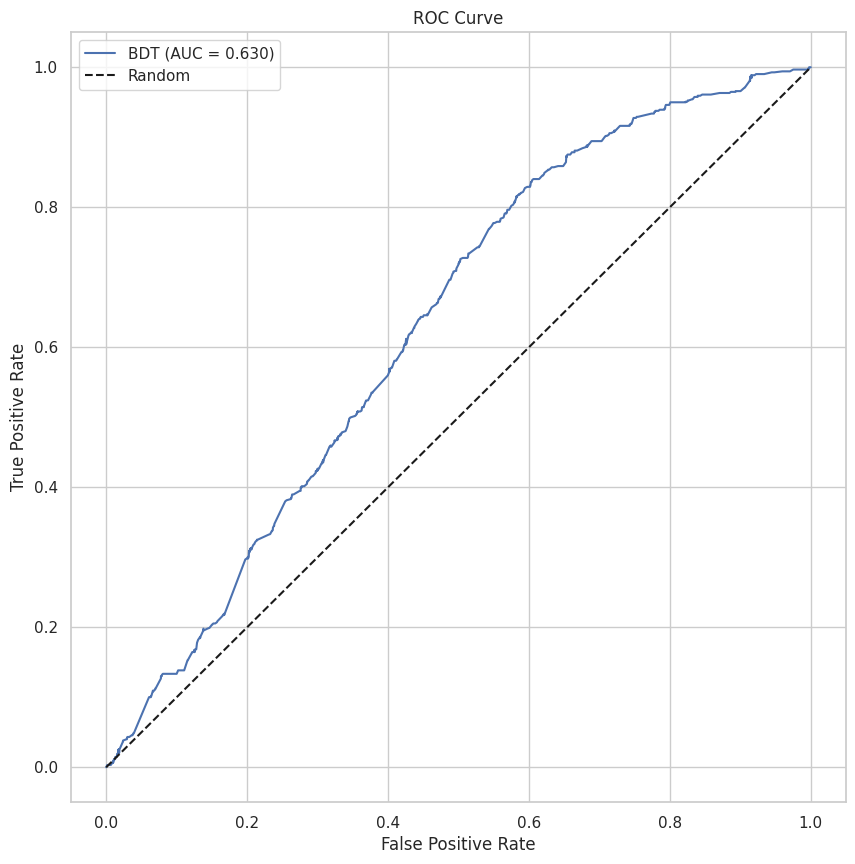

In [ ]:
# Create missing indicator columns and replace -999 with np.nan
missing_indicators = []  # to store names of the new indicator columns
for var in Vars:
    indicator = var + '_missing'
    # Indicator is 1 if the value equals -999, else 0
    df_all[indicator] = (df_all[var] == -999).astype(int)
    missing_indicators.append(indicator)
    # Replace -999 with NaN for imputation
    df_all[var] = df_all[var].replace(-999, np.nan)

# Impute missing values in each variable using median imputation
imputer = SimpleImputer(strategy='median')
df_all[Vars] = imputer.fit_transform(df_all[Vars])

# Define feature columns: include both the original variables and their missing indicators
feature_columns = Vars + missing_indicators

# Define the inputs and target
X = df_all[feature_columns]
y = df_all['label']
sample_weights = df_all['weights']

# Split the dataset into training and testing sets (stratifying on the label)
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(
    X, y, sample_weights, test_size=0.3, random_state=42, stratify=y
)

# Train a Boosted Decision Tree (using GradientBoostingClassifier)
bdt = GradientBoostingClassifier(random_state=42)
bdt.fit(X_train, y_train, sample_weight=sw_train)

Test ROC AUC: 0.630


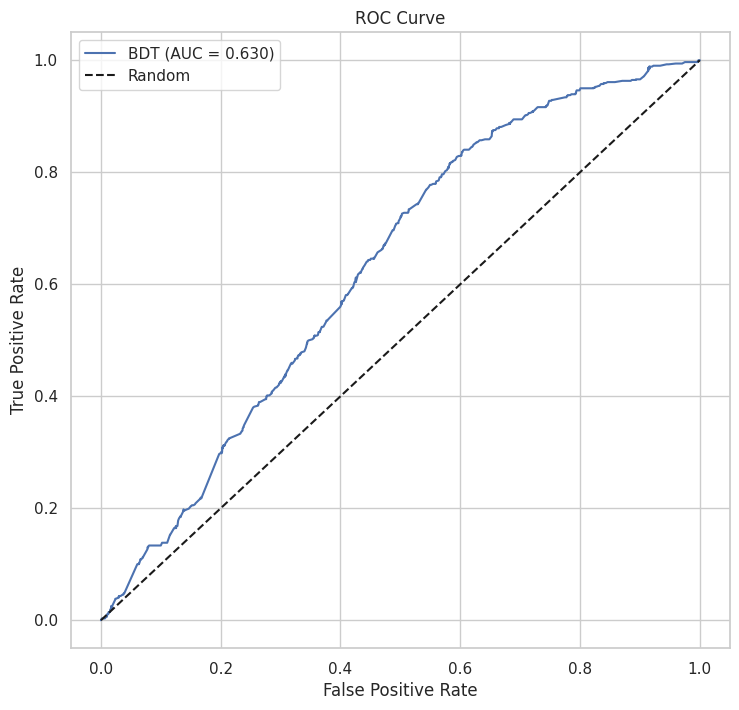

In [34]:
# Plotting ROC curve
y_pred_proba = bdt.predict_proba(X_test)[:, 1]

# Compute ROC curve (with sample weights)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, sample_weight=sw_test)

# Ensure fpr is monotonic by sorting (if needed)
sort_idx = np.argsort(fpr)
fpr_sorted = fpr[sort_idx]
tpr_sorted = tpr[sort_idx]

# Compute the area under the ROC curve
roc_auc = auc(fpr_sorted, tpr_sorted)
print("Test ROC AUC: {:.3f}".format(roc_auc))

# Plot the ROC curve
plt.figure(figsize=(8.5, 8))
plt.plot(fpr_sorted, tpr_sorted, label='BDT (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


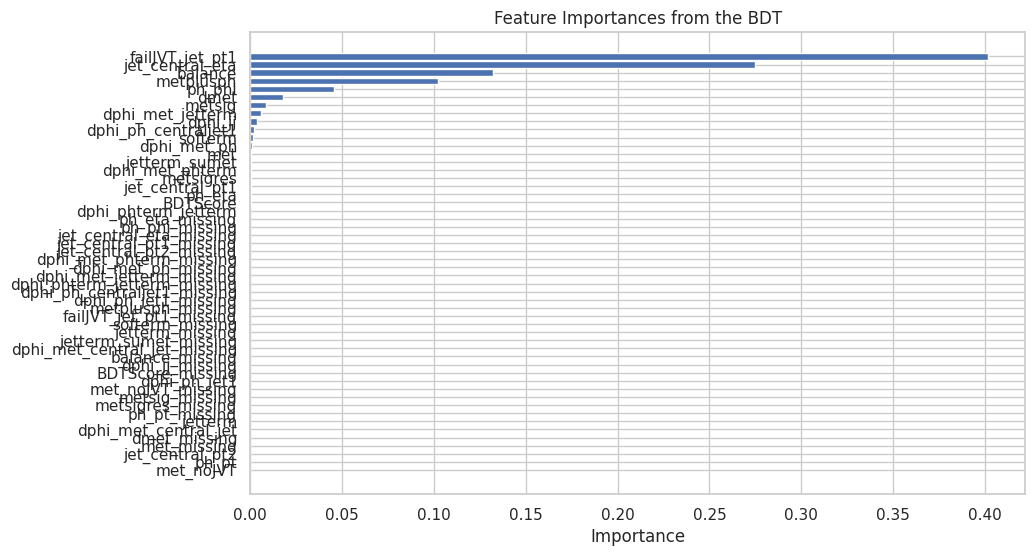

In [32]:
# Get feature importances from the BDT
importances = bdt.feature_importances_

# Sort the features by importance for a clearer plot
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_columns)), importances[indices], align='center')
plt.yticks(range(len(feature_columns)), [feature_columns[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances from the BDT')
plt.show()